# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

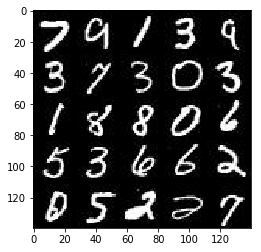

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

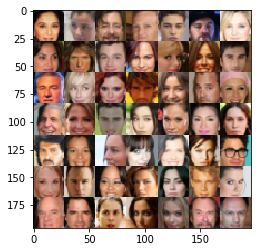

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), 
                                       name='real_input_images')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    
    return real_input_images, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse = reuse):
        # Define the convolution layers for image classification
        # we are going to use a 
        
        # input layer is 28x28ximage_channels
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(x1, x1 * 0.2)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2, bn2 * 0.2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3, bn3 * 0.2)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(x1, x1 * 0.2)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(x2, x2 * 0.2)
        # 7x7x256

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(x3, x3 * 0.2)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [11]:
class GAN:
    def __init__(self, image_width, image_height, image_channels, z_dim, learning_rate, beta1=0.5):
        
        self.input_real, self.input_z, self.learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
        #self.learn_rate = learning_rate
        
        self.d_loss, self.g_loss =  model_loss(self.input_real, self.input_z, image_channels)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    net = GAN(image_width = data_shape[1], image_height = data_shape[2], image_channels = data_shape[3], 
              z_dim = z_dim, learning_rate = learning_rate, beta1=beta1)
    
    saver = tf.train.Saver()
    
    steps = 0
    print_every = 10
    show_every = 100
    # number of images to show for generator
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                # rescale to [-1,1]
                batch_images = batch_images * 2
                
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(net.d_opt, feed_dict = {net.input_real: batch_images, net.input_z: batch_z, net.learn_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict = {net.input_real: batch_images, net.input_z: batch_z, net.learn_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict = {net.input_real: batch_images, net.input_z: batch_z, net.learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    
                    print("Epoch {}/{} Steps {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d), 
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, net.input_z, data_shape[3], data_image_mode)
            
            steps = 0
        
        print('Training done!')
        show_generator_output(sess, n_images, net.input_z, data_shape[3], data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Steps 10... Discriminator Loss: 3.4811... Generator Loss: 0.0418
Epoch 1/2 Steps 20... Discriminator Loss: 1.9242... Generator Loss: 0.1977
Epoch 1/2 Steps 30... Discriminator Loss: 2.4059... Generator Loss: 4.1893
Epoch 1/2 Steps 40... Discriminator Loss: 0.8348... Generator Loss: 1.1529
Epoch 1/2 Steps 50... Discriminator Loss: 1.7650... Generator Loss: 0.7486
Epoch 1/2 Steps 60... Discriminator Loss: 0.5432... Generator Loss: 1.6790
Epoch 1/2 Steps 70... Discriminator Loss: 0.5904... Generator Loss: 2.0014
Epoch 1/2 Steps 80... Discriminator Loss: 1.2985... Generator Loss: 1.3707
Epoch 1/2 Steps 90... Discriminator Loss: 1.1992... Generator Loss: 0.8491
Epoch 1/2 Steps 100... Discriminator Loss: 0.9577... Generator Loss: 1.5250


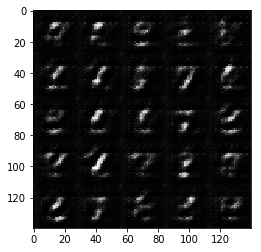

Epoch 1/2 Steps 110... Discriminator Loss: 1.2823... Generator Loss: 1.7175
Epoch 1/2 Steps 120... Discriminator Loss: 1.3505... Generator Loss: 0.6017
Epoch 1/2 Steps 130... Discriminator Loss: 1.0170... Generator Loss: 1.5218
Epoch 1/2 Steps 140... Discriminator Loss: 1.6341... Generator Loss: 0.4060
Epoch 1/2 Steps 150... Discriminator Loss: 1.4398... Generator Loss: 0.4810
Epoch 1/2 Steps 160... Discriminator Loss: 1.3420... Generator Loss: 1.5291
Epoch 1/2 Steps 170... Discriminator Loss: 1.2482... Generator Loss: 1.0678
Epoch 1/2 Steps 180... Discriminator Loss: 1.2222... Generator Loss: 0.7105
Epoch 1/2 Steps 190... Discriminator Loss: 1.3430... Generator Loss: 0.6318
Epoch 1/2 Steps 200... Discriminator Loss: 1.1409... Generator Loss: 1.0829


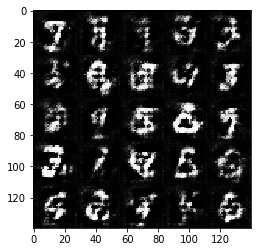

Epoch 1/2 Steps 210... Discriminator Loss: 1.7402... Generator Loss: 0.2791
Epoch 1/2 Steps 220... Discriminator Loss: 1.2779... Generator Loss: 0.8559
Epoch 1/2 Steps 230... Discriminator Loss: 1.3219... Generator Loss: 0.5230
Epoch 1/2 Steps 240... Discriminator Loss: 0.9877... Generator Loss: 0.9898
Epoch 1/2 Steps 250... Discriminator Loss: 1.3850... Generator Loss: 0.4886
Epoch 1/2 Steps 260... Discriminator Loss: 1.2111... Generator Loss: 1.1716
Epoch 1/2 Steps 270... Discriminator Loss: 1.5536... Generator Loss: 2.0031
Epoch 1/2 Steps 280... Discriminator Loss: 1.2012... Generator Loss: 1.2648
Epoch 1/2 Steps 290... Discriminator Loss: 1.0642... Generator Loss: 0.8981
Epoch 1/2 Steps 300... Discriminator Loss: 1.2653... Generator Loss: 1.3497


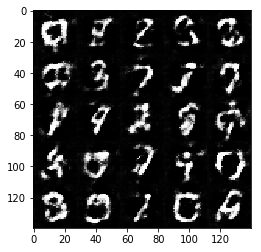

Epoch 1/2 Steps 310... Discriminator Loss: 1.2346... Generator Loss: 0.8628
Epoch 1/2 Steps 320... Discriminator Loss: 1.5553... Generator Loss: 0.3329
Epoch 1/2 Steps 330... Discriminator Loss: 1.4152... Generator Loss: 0.3712
Epoch 1/2 Steps 340... Discriminator Loss: 1.2623... Generator Loss: 0.4869
Epoch 1/2 Steps 350... Discriminator Loss: 1.1376... Generator Loss: 1.2766
Epoch 1/2 Steps 360... Discriminator Loss: 1.1712... Generator Loss: 0.5876
Epoch 1/2 Steps 370... Discriminator Loss: 1.1688... Generator Loss: 0.5853
Epoch 1/2 Steps 380... Discriminator Loss: 1.5034... Generator Loss: 0.3242
Epoch 1/2 Steps 390... Discriminator Loss: 1.2422... Generator Loss: 0.5767
Epoch 1/2 Steps 400... Discriminator Loss: 1.6098... Generator Loss: 0.3077


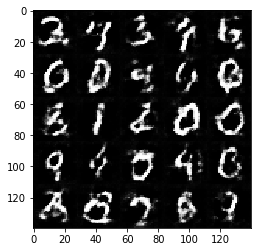

Epoch 1/2 Steps 410... Discriminator Loss: 1.0594... Generator Loss: 1.1196
Epoch 1/2 Steps 420... Discriminator Loss: 1.4390... Generator Loss: 0.4105
Epoch 1/2 Steps 430... Discriminator Loss: 1.7261... Generator Loss: 0.2700
Epoch 1/2 Steps 440... Discriminator Loss: 1.3703... Generator Loss: 0.4063
Epoch 1/2 Steps 450... Discriminator Loss: 1.2560... Generator Loss: 0.4935
Epoch 1/2 Steps 460... Discriminator Loss: 1.4160... Generator Loss: 0.3922
Epoch 1/2 Steps 470... Discriminator Loss: 1.4158... Generator Loss: 1.5687
Epoch 1/2 Steps 480... Discriminator Loss: 1.2814... Generator Loss: 0.4906
Epoch 1/2 Steps 490... Discriminator Loss: 1.1244... Generator Loss: 1.1023
Epoch 1/2 Steps 500... Discriminator Loss: 1.1268... Generator Loss: 0.9265


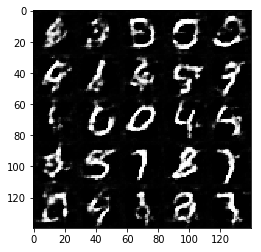

Epoch 1/2 Steps 510... Discriminator Loss: 1.2885... Generator Loss: 1.4231
Epoch 1/2 Steps 520... Discriminator Loss: 1.3204... Generator Loss: 0.4588
Epoch 1/2 Steps 530... Discriminator Loss: 1.4447... Generator Loss: 1.5683
Epoch 1/2 Steps 540... Discriminator Loss: 1.5537... Generator Loss: 0.3424
Epoch 1/2 Steps 550... Discriminator Loss: 1.2299... Generator Loss: 0.6156
Epoch 1/2 Steps 560... Discriminator Loss: 1.3354... Generator Loss: 0.6827
Epoch 1/2 Steps 570... Discriminator Loss: 1.5846... Generator Loss: 0.3208
Epoch 1/2 Steps 580... Discriminator Loss: 1.1076... Generator Loss: 0.9695
Epoch 1/2 Steps 590... Discriminator Loss: 1.5101... Generator Loss: 0.3590
Epoch 1/2 Steps 600... Discriminator Loss: 1.1476... Generator Loss: 0.8126


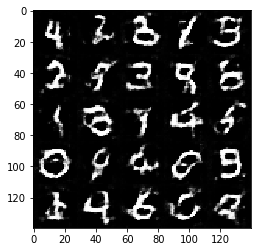

Epoch 1/2 Steps 610... Discriminator Loss: 1.1962... Generator Loss: 0.7571
Epoch 1/2 Steps 620... Discriminator Loss: 1.0718... Generator Loss: 0.7543
Epoch 1/2 Steps 630... Discriminator Loss: 1.0744... Generator Loss: 1.0160
Epoch 1/2 Steps 640... Discriminator Loss: 1.6103... Generator Loss: 0.2925
Epoch 1/2 Steps 650... Discriminator Loss: 1.1228... Generator Loss: 1.0930
Epoch 1/2 Steps 660... Discriminator Loss: 1.1967... Generator Loss: 1.1614
Epoch 1/2 Steps 670... Discriminator Loss: 1.1642... Generator Loss: 0.7283
Epoch 1/2 Steps 680... Discriminator Loss: 1.0926... Generator Loss: 0.9283
Epoch 1/2 Steps 690... Discriminator Loss: 0.9427... Generator Loss: 1.0321
Epoch 1/2 Steps 700... Discriminator Loss: 1.3747... Generator Loss: 1.1180


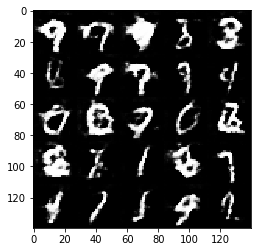

Epoch 1/2 Steps 710... Discriminator Loss: 1.2023... Generator Loss: 0.9501
Epoch 1/2 Steps 720... Discriminator Loss: 1.7300... Generator Loss: 0.2883
Epoch 1/2 Steps 730... Discriminator Loss: 1.0548... Generator Loss: 0.8490
Epoch 1/2 Steps 740... Discriminator Loss: 1.1377... Generator Loss: 0.6442
Epoch 1/2 Steps 750... Discriminator Loss: 0.9562... Generator Loss: 0.7245
Epoch 1/2 Steps 760... Discriminator Loss: 1.4794... Generator Loss: 1.9240
Epoch 1/2 Steps 770... Discriminator Loss: 1.1488... Generator Loss: 0.6326
Epoch 1/2 Steps 780... Discriminator Loss: 1.1451... Generator Loss: 0.8308
Epoch 1/2 Steps 790... Discriminator Loss: 2.1037... Generator Loss: 0.1623
Epoch 1/2 Steps 800... Discriminator Loss: 1.1125... Generator Loss: 0.6287


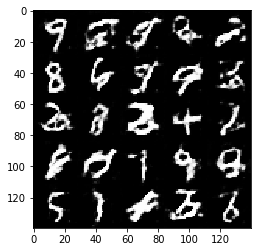

Epoch 1/2 Steps 810... Discriminator Loss: 1.1852... Generator Loss: 1.0959
Epoch 1/2 Steps 820... Discriminator Loss: 1.0314... Generator Loss: 0.6925
Epoch 1/2 Steps 830... Discriminator Loss: 1.1136... Generator Loss: 0.8090
Epoch 1/2 Steps 840... Discriminator Loss: 1.0683... Generator Loss: 0.7675
Epoch 1/2 Steps 850... Discriminator Loss: 1.3714... Generator Loss: 0.7524
Epoch 1/2 Steps 860... Discriminator Loss: 1.1963... Generator Loss: 0.6603
Epoch 1/2 Steps 870... Discriminator Loss: 1.1275... Generator Loss: 0.5192
Epoch 1/2 Steps 880... Discriminator Loss: 1.0840... Generator Loss: 0.9440
Epoch 1/2 Steps 890... Discriminator Loss: 1.1079... Generator Loss: 0.8939
Epoch 1/2 Steps 900... Discriminator Loss: 1.0966... Generator Loss: 0.6697


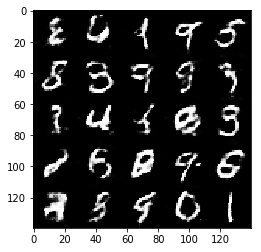

Epoch 1/2 Steps 910... Discriminator Loss: 1.5971... Generator Loss: 1.4871
Epoch 1/2 Steps 920... Discriminator Loss: 1.1414... Generator Loss: 0.5879
Epoch 1/2 Steps 930... Discriminator Loss: 1.3446... Generator Loss: 0.4313
Epoch 2/2 Steps 10... Discriminator Loss: 1.0111... Generator Loss: 1.0460
Epoch 2/2 Steps 20... Discriminator Loss: 1.4942... Generator Loss: 0.4160
Epoch 2/2 Steps 30... Discriminator Loss: 1.1572... Generator Loss: 1.1976
Epoch 2/2 Steps 40... Discriminator Loss: 1.0801... Generator Loss: 0.6633
Epoch 2/2 Steps 50... Discriminator Loss: 1.2636... Generator Loss: 0.9444
Epoch 2/2 Steps 60... Discriminator Loss: 1.2858... Generator Loss: 0.4978
Epoch 2/2 Steps 70... Discriminator Loss: 1.5564... Generator Loss: 0.3172
Epoch 2/2 Steps 80... Discriminator Loss: 1.2434... Generator Loss: 0.7249
Epoch 2/2 Steps 90... Discriminator Loss: 1.6527... Generator Loss: 0.2839
Epoch 2/2 Steps 100... Discriminator Loss: 1.4566... Generator Loss: 0.3804


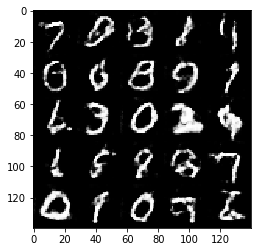

Epoch 2/2 Steps 110... Discriminator Loss: 1.2358... Generator Loss: 0.4482
Epoch 2/2 Steps 120... Discriminator Loss: 1.1061... Generator Loss: 0.7428
Epoch 2/2 Steps 130... Discriminator Loss: 1.2549... Generator Loss: 0.4890
Epoch 2/2 Steps 140... Discriminator Loss: 1.1638... Generator Loss: 0.6608
Epoch 2/2 Steps 150... Discriminator Loss: 0.8468... Generator Loss: 1.0959
Epoch 2/2 Steps 160... Discriminator Loss: 1.0951... Generator Loss: 0.9250
Epoch 2/2 Steps 170... Discriminator Loss: 1.4393... Generator Loss: 0.3528
Epoch 2/2 Steps 180... Discriminator Loss: 1.1853... Generator Loss: 0.6545
Epoch 2/2 Steps 190... Discriminator Loss: 1.3591... Generator Loss: 0.3858
Epoch 2/2 Steps 200... Discriminator Loss: 2.8809... Generator Loss: 3.4024


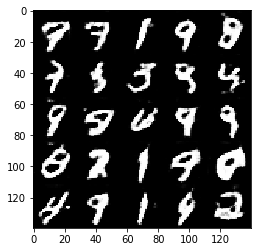

Epoch 2/2 Steps 210... Discriminator Loss: 1.5136... Generator Loss: 0.3238
Epoch 2/2 Steps 220... Discriminator Loss: 0.9711... Generator Loss: 0.8308
Epoch 2/2 Steps 230... Discriminator Loss: 1.6628... Generator Loss: 0.2601
Epoch 2/2 Steps 240... Discriminator Loss: 0.9423... Generator Loss: 1.3251
Epoch 2/2 Steps 250... Discriminator Loss: 1.8477... Generator Loss: 0.2197
Epoch 2/2 Steps 260... Discriminator Loss: 1.2950... Generator Loss: 0.5888
Epoch 2/2 Steps 270... Discriminator Loss: 1.0927... Generator Loss: 0.5742
Epoch 2/2 Steps 280... Discriminator Loss: 1.3426... Generator Loss: 0.4202
Epoch 2/2 Steps 290... Discriminator Loss: 1.5019... Generator Loss: 2.3478
Epoch 2/2 Steps 300... Discriminator Loss: 1.3882... Generator Loss: 1.3272


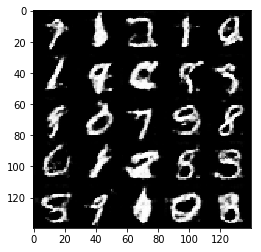

Epoch 2/2 Steps 310... Discriminator Loss: 1.0261... Generator Loss: 1.0197
Epoch 2/2 Steps 320... Discriminator Loss: 1.3360... Generator Loss: 0.6805
Epoch 2/2 Steps 330... Discriminator Loss: 0.9883... Generator Loss: 0.7026
Epoch 2/2 Steps 340... Discriminator Loss: 1.3082... Generator Loss: 0.4225
Epoch 2/2 Steps 350... Discriminator Loss: 1.2511... Generator Loss: 0.4600
Epoch 2/2 Steps 360... Discriminator Loss: 1.2636... Generator Loss: 0.9775
Epoch 2/2 Steps 370... Discriminator Loss: 1.2415... Generator Loss: 0.6346
Epoch 2/2 Steps 380... Discriminator Loss: 1.0124... Generator Loss: 0.6990
Epoch 2/2 Steps 390... Discriminator Loss: 2.4917... Generator Loss: 0.1115
Epoch 2/2 Steps 400... Discriminator Loss: 1.2546... Generator Loss: 0.5935


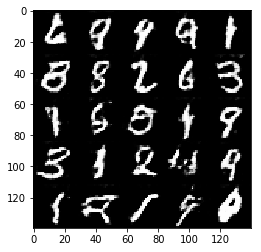

Epoch 2/2 Steps 410... Discriminator Loss: 0.9581... Generator Loss: 0.9472
Epoch 2/2 Steps 420... Discriminator Loss: 0.9072... Generator Loss: 0.8553
Epoch 2/2 Steps 430... Discriminator Loss: 0.9818... Generator Loss: 1.3720
Epoch 2/2 Steps 440... Discriminator Loss: 1.1640... Generator Loss: 0.6494
Epoch 2/2 Steps 450... Discriminator Loss: 1.0792... Generator Loss: 0.8879
Epoch 2/2 Steps 460... Discriminator Loss: 1.0456... Generator Loss: 0.8139
Epoch 2/2 Steps 470... Discriminator Loss: 1.2893... Generator Loss: 0.4200
Epoch 2/2 Steps 480... Discriminator Loss: 1.0122... Generator Loss: 0.6997
Epoch 2/2 Steps 490... Discriminator Loss: 1.4725... Generator Loss: 2.3102
Epoch 2/2 Steps 500... Discriminator Loss: 0.9943... Generator Loss: 1.0531


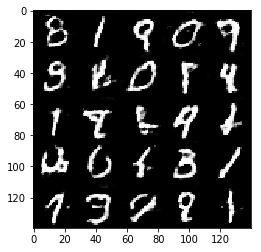

Epoch 2/2 Steps 510... Discriminator Loss: 1.4918... Generator Loss: 0.3289
Epoch 2/2 Steps 520... Discriminator Loss: 1.2982... Generator Loss: 0.5021
Epoch 2/2 Steps 530... Discriminator Loss: 3.5259... Generator Loss: 4.8016
Epoch 2/2 Steps 540... Discriminator Loss: 1.3689... Generator Loss: 0.4766
Epoch 2/2 Steps 550... Discriminator Loss: 2.0599... Generator Loss: 0.2183
Epoch 2/2 Steps 560... Discriminator Loss: 1.2397... Generator Loss: 0.6128
Epoch 2/2 Steps 570... Discriminator Loss: 0.8568... Generator Loss: 1.2389
Epoch 2/2 Steps 580... Discriminator Loss: 1.3927... Generator Loss: 0.3960
Epoch 2/2 Steps 590... Discriminator Loss: 0.8379... Generator Loss: 0.9354
Epoch 2/2 Steps 600... Discriminator Loss: 1.2782... Generator Loss: 0.5154


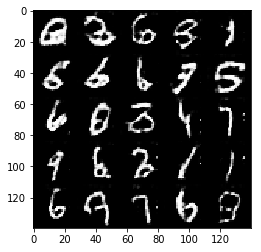

Epoch 2/2 Steps 610... Discriminator Loss: 0.9278... Generator Loss: 1.0185
Epoch 2/2 Steps 620... Discriminator Loss: 0.9051... Generator Loss: 0.8488
Epoch 2/2 Steps 630... Discriminator Loss: 0.7733... Generator Loss: 1.6377
Epoch 2/2 Steps 640... Discriminator Loss: 0.9908... Generator Loss: 0.8942
Epoch 2/2 Steps 650... Discriminator Loss: 1.2682... Generator Loss: 0.5093
Epoch 2/2 Steps 660... Discriminator Loss: 1.1833... Generator Loss: 1.1882
Epoch 2/2 Steps 670... Discriminator Loss: 1.4493... Generator Loss: 0.4031
Epoch 2/2 Steps 680... Discriminator Loss: 0.8449... Generator Loss: 0.8734
Epoch 2/2 Steps 690... Discriminator Loss: 1.0265... Generator Loss: 0.8438
Epoch 2/2 Steps 700... Discriminator Loss: 1.4378... Generator Loss: 0.3713


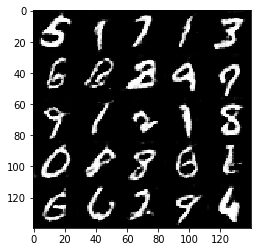

Epoch 2/2 Steps 710... Discriminator Loss: 0.9482... Generator Loss: 0.9786
Epoch 2/2 Steps 720... Discriminator Loss: 1.5613... Generator Loss: 0.3097
Epoch 2/2 Steps 730... Discriminator Loss: 1.2299... Generator Loss: 0.4655
Epoch 2/2 Steps 740... Discriminator Loss: 3.3176... Generator Loss: 4.5905
Epoch 2/2 Steps 750... Discriminator Loss: 1.0842... Generator Loss: 0.6622
Epoch 2/2 Steps 760... Discriminator Loss: 0.7585... Generator Loss: 0.9161
Epoch 2/2 Steps 770... Discriminator Loss: 1.0628... Generator Loss: 0.6671
Epoch 2/2 Steps 780... Discriminator Loss: 0.7728... Generator Loss: 0.9618
Epoch 2/2 Steps 790... Discriminator Loss: 0.9870... Generator Loss: 0.6807
Epoch 2/2 Steps 800... Discriminator Loss: 1.2022... Generator Loss: 0.5179


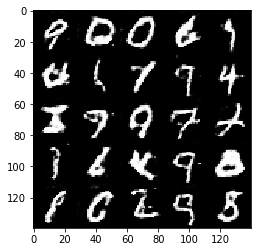

Epoch 2/2 Steps 810... Discriminator Loss: 0.6184... Generator Loss: 1.3657
Epoch 2/2 Steps 820... Discriminator Loss: 1.1741... Generator Loss: 0.5541
Epoch 2/2 Steps 830... Discriminator Loss: 3.7399... Generator Loss: 3.5356
Epoch 2/2 Steps 840... Discriminator Loss: 1.4932... Generator Loss: 0.4335
Epoch 2/2 Steps 850... Discriminator Loss: 1.0012... Generator Loss: 1.0047
Epoch 2/2 Steps 860... Discriminator Loss: 1.2786... Generator Loss: 0.4739
Epoch 2/2 Steps 870... Discriminator Loss: 0.6472... Generator Loss: 1.4013
Epoch 2/2 Steps 880... Discriminator Loss: 2.2012... Generator Loss: 0.1539
Epoch 2/2 Steps 890... Discriminator Loss: 1.5817... Generator Loss: 0.3198
Epoch 2/2 Steps 900... Discriminator Loss: 0.8176... Generator Loss: 0.9473


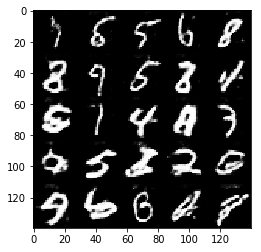

Epoch 2/2 Steps 910... Discriminator Loss: 1.3381... Generator Loss: 0.4149
Epoch 2/2 Steps 920... Discriminator Loss: 1.1759... Generator Loss: 0.5412
Epoch 2/2 Steps 930... Discriminator Loss: 1.0888... Generator Loss: 0.5809
Training done!


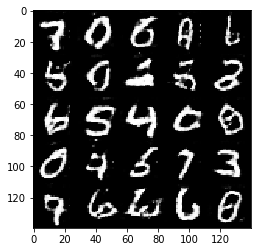

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Steps 10... Discriminator Loss: 5.6490... Generator Loss: 0.0072
Epoch 1/1 Steps 20... Discriminator Loss: 2.3775... Generator Loss: 8.8739
Epoch 1/1 Steps 30... Discriminator Loss: 1.9902... Generator Loss: 5.0151
Epoch 1/1 Steps 40... Discriminator Loss: 1.6140... Generator Loss: 1.5953
Epoch 1/1 Steps 50... Discriminator Loss: 2.0185... Generator Loss: 0.1862
Epoch 1/1 Steps 60... Discriminator Loss: 1.7115... Generator Loss: 1.0493
Epoch 1/1 Steps 70... Discriminator Loss: 0.9286... Generator Loss: 2.2999
Epoch 1/1 Steps 80... Discriminator Loss: 0.2605... Generator Loss: 2.4133
Epoch 1/1 Steps 90... Discriminator Loss: 1.4318... Generator Loss: 0.5889
Epoch 1/1 Steps 100... Discriminator Loss: 1.3643... Generator Loss: 0.9139


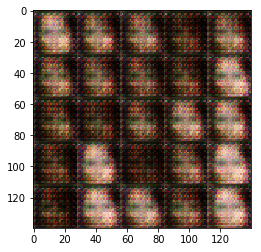

Epoch 1/1 Steps 110... Discriminator Loss: 1.0834... Generator Loss: 0.7125
Epoch 1/1 Steps 120... Discriminator Loss: 1.1121... Generator Loss: 0.8055
Epoch 1/1 Steps 130... Discriminator Loss: 1.7032... Generator Loss: 0.8244
Epoch 1/1 Steps 140... Discriminator Loss: 1.5493... Generator Loss: 0.6102
Epoch 1/1 Steps 150... Discriminator Loss: 1.1688... Generator Loss: 0.9596
Epoch 1/1 Steps 160... Discriminator Loss: 2.0667... Generator Loss: 0.9203
Epoch 1/1 Steps 170... Discriminator Loss: 2.7742... Generator Loss: 0.3320
Epoch 1/1 Steps 180... Discriminator Loss: 1.3389... Generator Loss: 0.7392
Epoch 1/1 Steps 190... Discriminator Loss: 1.1244... Generator Loss: 0.7308
Epoch 1/1 Steps 200... Discriminator Loss: 1.3624... Generator Loss: 0.9875


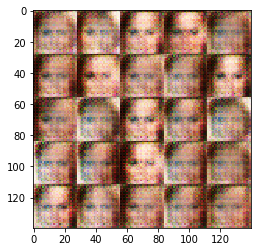

Epoch 1/1 Steps 210... Discriminator Loss: 1.9501... Generator Loss: 0.8404
Epoch 1/1 Steps 220... Discriminator Loss: 1.6669... Generator Loss: 0.7520
Epoch 1/1 Steps 230... Discriminator Loss: 1.2414... Generator Loss: 0.8598
Epoch 1/1 Steps 240... Discriminator Loss: 1.1344... Generator Loss: 0.8014
Epoch 1/1 Steps 250... Discriminator Loss: 1.5562... Generator Loss: 0.7084
Epoch 1/1 Steps 260... Discriminator Loss: 1.2156... Generator Loss: 0.9315
Epoch 1/1 Steps 270... Discriminator Loss: 1.1104... Generator Loss: 1.0256
Epoch 1/1 Steps 280... Discriminator Loss: 1.6069... Generator Loss: 0.5273
Epoch 1/1 Steps 290... Discriminator Loss: 1.3613... Generator Loss: 1.0919
Epoch 1/1 Steps 300... Discriminator Loss: 1.5847... Generator Loss: 0.7088


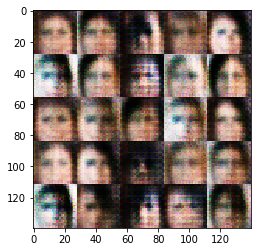

Epoch 1/1 Steps 310... Discriminator Loss: 1.5164... Generator Loss: 0.7570
Epoch 1/1 Steps 320... Discriminator Loss: 1.6136... Generator Loss: 0.7978
Epoch 1/1 Steps 330... Discriminator Loss: 1.6904... Generator Loss: 0.6910
Epoch 1/1 Steps 340... Discriminator Loss: 1.2256... Generator Loss: 0.8920
Epoch 1/1 Steps 350... Discriminator Loss: 1.4384... Generator Loss: 0.7019
Epoch 1/1 Steps 360... Discriminator Loss: 1.3103... Generator Loss: 0.8491
Epoch 1/1 Steps 370... Discriminator Loss: 1.6870... Generator Loss: 0.5554
Epoch 1/1 Steps 380... Discriminator Loss: 1.5642... Generator Loss: 0.5931
Epoch 1/1 Steps 390... Discriminator Loss: 1.3821... Generator Loss: 0.8199
Epoch 1/1 Steps 400... Discriminator Loss: 1.3088... Generator Loss: 0.8214


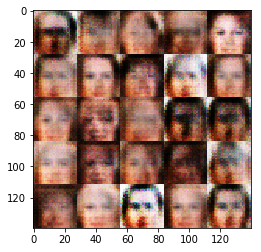

Epoch 1/1 Steps 410... Discriminator Loss: 1.4561... Generator Loss: 0.7667
Epoch 1/1 Steps 420... Discriminator Loss: 1.2373... Generator Loss: 0.9115
Epoch 1/1 Steps 430... Discriminator Loss: 1.2692... Generator Loss: 0.7883
Epoch 1/1 Steps 440... Discriminator Loss: 1.4362... Generator Loss: 0.6604
Epoch 1/1 Steps 450... Discriminator Loss: 1.4622... Generator Loss: 0.9005
Epoch 1/1 Steps 460... Discriminator Loss: 1.6636... Generator Loss: 0.4478
Epoch 1/1 Steps 470... Discriminator Loss: 1.3610... Generator Loss: 0.7555
Epoch 1/1 Steps 480... Discriminator Loss: 1.2886... Generator Loss: 0.9525
Epoch 1/1 Steps 490... Discriminator Loss: 1.4982... Generator Loss: 0.7358
Epoch 1/1 Steps 500... Discriminator Loss: 1.8068... Generator Loss: 0.6852


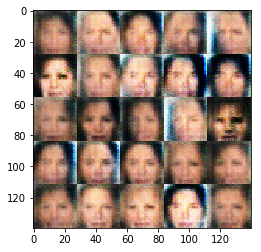

Epoch 1/1 Steps 510... Discriminator Loss: 1.3896... Generator Loss: 0.8936
Epoch 1/1 Steps 520... Discriminator Loss: 1.2412... Generator Loss: 0.8149
Epoch 1/1 Steps 530... Discriminator Loss: 1.2588... Generator Loss: 0.7284
Epoch 1/1 Steps 540... Discriminator Loss: 1.3435... Generator Loss: 0.8066
Epoch 1/1 Steps 550... Discriminator Loss: 1.1831... Generator Loss: 0.9928
Epoch 1/1 Steps 560... Discriminator Loss: 1.4639... Generator Loss: 0.8164
Epoch 1/1 Steps 570... Discriminator Loss: 1.3443... Generator Loss: 0.6664
Epoch 1/1 Steps 580... Discriminator Loss: 1.3761... Generator Loss: 0.7856
Epoch 1/1 Steps 590... Discriminator Loss: 1.4861... Generator Loss: 0.7854
Epoch 1/1 Steps 600... Discriminator Loss: 1.5708... Generator Loss: 0.6229


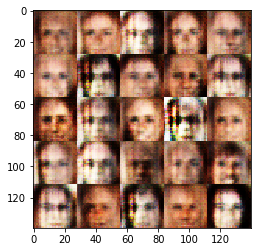

Epoch 1/1 Steps 610... Discriminator Loss: 1.4614... Generator Loss: 0.6436
Epoch 1/1 Steps 620... Discriminator Loss: 1.4374... Generator Loss: 0.5882
Epoch 1/1 Steps 630... Discriminator Loss: 1.4051... Generator Loss: 0.7535
Epoch 1/1 Steps 640... Discriminator Loss: 1.4709... Generator Loss: 0.6341
Epoch 1/1 Steps 650... Discriminator Loss: 1.4191... Generator Loss: 0.7505
Epoch 1/1 Steps 660... Discriminator Loss: 1.3478... Generator Loss: 0.7838
Epoch 1/1 Steps 670... Discriminator Loss: 1.5520... Generator Loss: 0.7533
Epoch 1/1 Steps 680... Discriminator Loss: 1.5209... Generator Loss: 0.8626
Epoch 1/1 Steps 690... Discriminator Loss: 1.5470... Generator Loss: 0.5998
Epoch 1/1 Steps 700... Discriminator Loss: 1.3601... Generator Loss: 0.7672


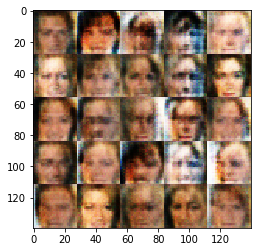

Epoch 1/1 Steps 710... Discriminator Loss: 1.4948... Generator Loss: 0.5431
Epoch 1/1 Steps 720... Discriminator Loss: 1.3695... Generator Loss: 0.8337
Epoch 1/1 Steps 730... Discriminator Loss: 1.4321... Generator Loss: 0.7396
Epoch 1/1 Steps 740... Discriminator Loss: 1.4932... Generator Loss: 0.6630
Epoch 1/1 Steps 750... Discriminator Loss: 1.2934... Generator Loss: 0.8647
Epoch 1/1 Steps 760... Discriminator Loss: 1.4748... Generator Loss: 0.6293
Epoch 1/1 Steps 770... Discriminator Loss: 1.4741... Generator Loss: 0.6618
Epoch 1/1 Steps 780... Discriminator Loss: 1.3956... Generator Loss: 0.7097
Epoch 1/1 Steps 790... Discriminator Loss: 1.4067... Generator Loss: 1.0043
Epoch 1/1 Steps 800... Discriminator Loss: 1.4749... Generator Loss: 0.6710


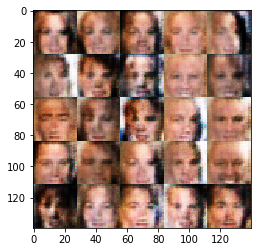

Epoch 1/1 Steps 810... Discriminator Loss: 1.5002... Generator Loss: 0.6602
Epoch 1/1 Steps 820... Discriminator Loss: 1.4872... Generator Loss: 0.6138
Epoch 1/1 Steps 830... Discriminator Loss: 1.5407... Generator Loss: 0.6494
Epoch 1/1 Steps 840... Discriminator Loss: 1.6065... Generator Loss: 0.6457
Epoch 1/1 Steps 850... Discriminator Loss: 1.4607... Generator Loss: 0.6578
Epoch 1/1 Steps 860... Discriminator Loss: 1.5106... Generator Loss: 0.7150
Epoch 1/1 Steps 870... Discriminator Loss: 1.5070... Generator Loss: 0.6196
Epoch 1/1 Steps 880... Discriminator Loss: 1.5290... Generator Loss: 0.6933
Epoch 1/1 Steps 890... Discriminator Loss: 1.5938... Generator Loss: 0.5535
Epoch 1/1 Steps 900... Discriminator Loss: 1.5596... Generator Loss: 0.6033


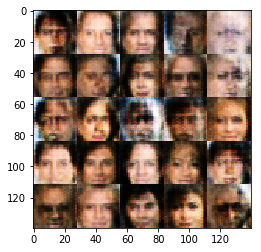

Epoch 1/1 Steps 910... Discriminator Loss: 1.3823... Generator Loss: 0.7721
Epoch 1/1 Steps 920... Discriminator Loss: 1.4432... Generator Loss: 0.6561
Epoch 1/1 Steps 930... Discriminator Loss: 1.3944... Generator Loss: 0.6635
Epoch 1/1 Steps 940... Discriminator Loss: 1.3934... Generator Loss: 0.6712
Epoch 1/1 Steps 950... Discriminator Loss: 1.5092... Generator Loss: 0.6012
Epoch 1/1 Steps 960... Discriminator Loss: 1.3637... Generator Loss: 0.6354
Epoch 1/1 Steps 970... Discriminator Loss: 1.3912... Generator Loss: 0.6117
Epoch 1/1 Steps 980... Discriminator Loss: 1.5303... Generator Loss: 0.7382
Epoch 1/1 Steps 990... Discriminator Loss: 1.3836... Generator Loss: 0.7963
Epoch 1/1 Steps 1000... Discriminator Loss: 1.4697... Generator Loss: 0.7178


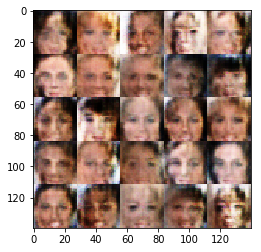

Epoch 1/1 Steps 1010... Discriminator Loss: 1.4176... Generator Loss: 0.6603
Epoch 1/1 Steps 1020... Discriminator Loss: 1.5994... Generator Loss: 0.5884
Epoch 1/1 Steps 1030... Discriminator Loss: 1.4634... Generator Loss: 0.6973
Epoch 1/1 Steps 1040... Discriminator Loss: 1.5039... Generator Loss: 0.8036
Epoch 1/1 Steps 1050... Discriminator Loss: 1.3481... Generator Loss: 0.7082
Epoch 1/1 Steps 1060... Discriminator Loss: 1.4960... Generator Loss: 0.6239
Epoch 1/1 Steps 1070... Discriminator Loss: 1.4476... Generator Loss: 0.6161
Epoch 1/1 Steps 1080... Discriminator Loss: 1.3857... Generator Loss: 0.7454
Epoch 1/1 Steps 1090... Discriminator Loss: 1.5293... Generator Loss: 0.7013
Epoch 1/1 Steps 1100... Discriminator Loss: 1.3510... Generator Loss: 0.7126


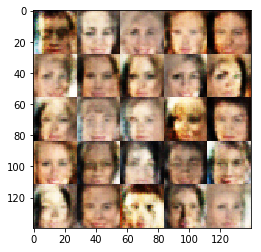

Epoch 1/1 Steps 1110... Discriminator Loss: 1.5332... Generator Loss: 0.6754
Epoch 1/1 Steps 1120... Discriminator Loss: 1.5255... Generator Loss: 0.6978
Epoch 1/1 Steps 1130... Discriminator Loss: 1.4247... Generator Loss: 0.6964
Epoch 1/1 Steps 1140... Discriminator Loss: 1.3759... Generator Loss: 0.7355
Epoch 1/1 Steps 1150... Discriminator Loss: 1.4360... Generator Loss: 0.7566
Epoch 1/1 Steps 1160... Discriminator Loss: 1.3918... Generator Loss: 0.7401
Epoch 1/1 Steps 1170... Discriminator Loss: 1.4403... Generator Loss: 0.6416
Epoch 1/1 Steps 1180... Discriminator Loss: 1.3985... Generator Loss: 0.6954
Epoch 1/1 Steps 1190... Discriminator Loss: 1.3585... Generator Loss: 0.7672
Epoch 1/1 Steps 1200... Discriminator Loss: 1.5303... Generator Loss: 0.6814


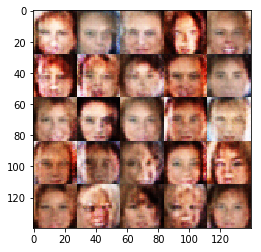

Epoch 1/1 Steps 1210... Discriminator Loss: 1.4536... Generator Loss: 0.6474
Epoch 1/1 Steps 1220... Discriminator Loss: 1.5407... Generator Loss: 0.6106
Epoch 1/1 Steps 1230... Discriminator Loss: 1.4248... Generator Loss: 0.6727
Epoch 1/1 Steps 1240... Discriminator Loss: 1.4156... Generator Loss: 0.8281
Epoch 1/1 Steps 1250... Discriminator Loss: 1.5482... Generator Loss: 0.6336
Epoch 1/1 Steps 1260... Discriminator Loss: 1.3239... Generator Loss: 0.7184
Epoch 1/1 Steps 1270... Discriminator Loss: 1.3550... Generator Loss: 0.7137
Epoch 1/1 Steps 1280... Discriminator Loss: 1.4127... Generator Loss: 0.7195
Epoch 1/1 Steps 1290... Discriminator Loss: 1.3988... Generator Loss: 0.6429
Epoch 1/1 Steps 1300... Discriminator Loss: 1.5461... Generator Loss: 0.6879


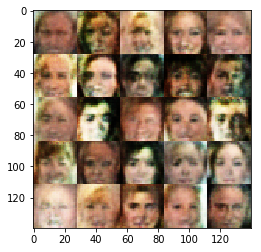

Epoch 1/1 Steps 1310... Discriminator Loss: 1.3705... Generator Loss: 0.7252
Epoch 1/1 Steps 1320... Discriminator Loss: 1.3913... Generator Loss: 0.6435
Epoch 1/1 Steps 1330... Discriminator Loss: 1.3315... Generator Loss: 0.7245
Epoch 1/1 Steps 1340... Discriminator Loss: 1.4685... Generator Loss: 0.6473
Epoch 1/1 Steps 1350... Discriminator Loss: 1.3982... Generator Loss: 0.7028
Epoch 1/1 Steps 1360... Discriminator Loss: 1.4275... Generator Loss: 0.6647
Epoch 1/1 Steps 1370... Discriminator Loss: 1.3383... Generator Loss: 0.7165
Epoch 1/1 Steps 1380... Discriminator Loss: 1.5414... Generator Loss: 0.7315
Epoch 1/1 Steps 1390... Discriminator Loss: 1.4421... Generator Loss: 0.6631
Epoch 1/1 Steps 1400... Discriminator Loss: 1.4802... Generator Loss: 0.6055


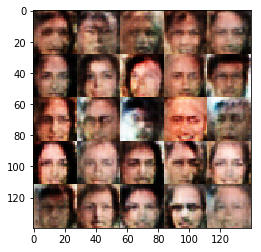

Epoch 1/1 Steps 1410... Discriminator Loss: 1.4444... Generator Loss: 0.6682
Epoch 1/1 Steps 1420... Discriminator Loss: 1.3550... Generator Loss: 0.6552
Epoch 1/1 Steps 1430... Discriminator Loss: 1.3888... Generator Loss: 0.6725
Epoch 1/1 Steps 1440... Discriminator Loss: 1.4252... Generator Loss: 0.6461
Epoch 1/1 Steps 1450... Discriminator Loss: 1.3459... Generator Loss: 0.5597
Epoch 1/1 Steps 1460... Discriminator Loss: 1.5229... Generator Loss: 0.7322
Epoch 1/1 Steps 1470... Discriminator Loss: 1.5381... Generator Loss: 0.5738
Epoch 1/1 Steps 1480... Discriminator Loss: 1.3688... Generator Loss: 0.5809
Epoch 1/1 Steps 1490... Discriminator Loss: 1.5007... Generator Loss: 0.6844
Epoch 1/1 Steps 1500... Discriminator Loss: 1.5723... Generator Loss: 0.6981


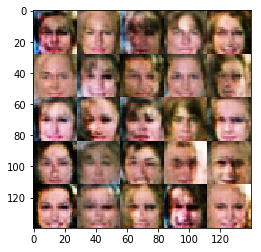

Epoch 1/1 Steps 1510... Discriminator Loss: 1.5495... Generator Loss: 0.5912
Epoch 1/1 Steps 1520... Discriminator Loss: 1.4024... Generator Loss: 0.7632
Epoch 1/1 Steps 1530... Discriminator Loss: 1.4491... Generator Loss: 0.5711
Epoch 1/1 Steps 1540... Discriminator Loss: 1.3423... Generator Loss: 0.6929
Epoch 1/1 Steps 1550... Discriminator Loss: 1.4308... Generator Loss: 0.6640
Epoch 1/1 Steps 1560... Discriminator Loss: 1.3881... Generator Loss: 0.6383
Epoch 1/1 Steps 1570... Discriminator Loss: 1.3751... Generator Loss: 0.7090
Epoch 1/1 Steps 1580... Discriminator Loss: 1.3808... Generator Loss: 0.6618
Training done!


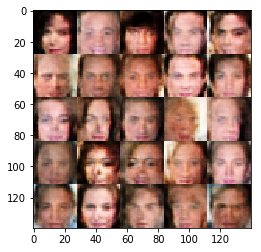

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.